In [1]:
import os
import sys
import json
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch
import networkx as nx
import numpy as np
from enum import Enum
from typing import Dict, List, Tuple, Set
import pandas as pd
from datetime import datetime


# Project paths setup
project_root = os.path.abspath(".")  # Current directory
implementation_path = os.path.join(project_root, "Implementation")
app_path = os.path.join(project_root, "App")
new_semantics_path = os.path.join(project_root, "NewSemantics") 

# Add paths to sys.path
for path in [implementation_path, app_path, new_semantics_path]:
    if path not in sys.path:
        sys.path.append(path)

from Implementation.enums import ElementStatus, QualityStatus, LinkType, LinkStatus
from NewSemantics.goal_model import GoalModel
from NewSemantics.istar_processor import read_istar_model
from Ui.Layout import Layout

print("All libraries imported successfully!")


All libraries imported successfully!


In [ ]:
# Global state initialization
if 'executed_events' not in globals():
    executed_events = []

if 'interface_created' not in globals():
    interface_created = False

if 'handler_debug' not in globals():
    handler_debug = False

if 'last_update' not in globals():
    last_update = datetime.utcnow()


In [3]:
def create_model_from_your_code():
    filepath = "Data/example_from_paper.txt"
    return read_istar_model(filepath)

def get_status_color_from_your_model(element_id):
    if element_id in model.qualities:
        status = model.qualities[element_id]
        if status == QualityStatus.UNKNOWN:
            return 'white'
        elif status == QualityStatus.FULFILLED:
            return 'lightgreen'
        elif status == QualityStatus.DENIED:
            return 'lightcoral'
    else:
        status = model.tasks.get(element_id) or model.goals.get(element_id)
        if status == ElementStatus.UNKNOWN:
            return 'white'
        elif status == ElementStatus.TRUE_FALSE:
            return 'lightgreen'
        elif status == ElementStatus.TRUE_TRUE:
            return 'lightblue'
    return 'white'

# Initialize model
model = create_model_from_your_code()
print("Model and helper functions initialized!")

Model and helper functions initialized!


In [4]:
def create_complete_interface():
    """Create the complete interface with controls on the left side (20% width)"""
    global interface_created, handler_debug
    
    # Header
    header = widgets.HTML(f"""
    <div style='text-align: center; margin-bottom: 20px;'>
        <h1 style='color: #2E86AB; margin-bottom: 10px;'>A unified view - Interactive High-Level Business Requirements Evaluation</h1>
        <p style='font-size: 14px; color: #666;'>Using GoalModel class from: {implementation_path}</p>
        <p style='font-size: 12px; color: #888;'>Last Updated: {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')} UTC</p>
    </div>
    """)
    
    # Legend remains the same
    legend = widgets.HTML("""
    <div style='background-color: #f0f0f0; padding: 10px; border-radius: 5px; margin-bottom: 15px; font-size: 12px; border: 1px solid #ccc;'>
    <div style='font-weight: bold; margin-bottom: 8px; text-align: center;'>Conventions</div>
    <div><strong>Colors:</strong> 🤍 Unknown | 🟢 Satisfied/Fulfilled | 🔵 Executed Pending | 🔴 Denied</div>
    <div><strong>Shapes:</strong> ☁️ Quality | ⭕ Goal | ⬡ Task | ⬜ Process Transition</div>
    </div>
    """)
    
    # Create output widgets
    trace_output = widgets.Output()
    status_output = widgets.Output()
    viz_output = widgets.Output()
    debug_output = widgets.Output() if handler_debug else None
    
    # Controls - Modified for vertical layout in sidebar
    process_dropdown = widgets.Dropdown(
        options=list(model.event_mapping.keys()),
        value=list(model.event_mapping.keys())[0],
        description='Event:',
        disabled=False,
        layout=widgets.Layout(width='100%', margin='5px 0px')
    )
    
    execute_button = widgets.Button(
        description='Execute Event',
        disabled=False,
        button_style='success',
        tooltip='Execute the selected event',
        layout=widgets.Layout(width='100%', margin='5px 0px')
    )
    
    reset_button = widgets.Button(
        description='Reset Model',
        disabled=False,
        button_style='warning',
        tooltip='Reset the model to initial state',
        layout=widgets.Layout(width='100%', margin='5px 0px')
    )

    # Update functions remain the same
    def update_trace():
        with trace_output:
            clear_output(wait=True)
            trace_html = """
            <div style='border: 2px solid #ccc; padding: 15px; margin: 10px; background-color: #f9f9f9;'>
                <h3>Trace Execution Timeline</h3>
            """
            if not executed_events:
                trace_html += "<p>No events executed yet. Select an event and click 'Execute Event' to start.</p>"
            else:
                trace_html += "<div style='display: flex; align-items: center; gap: 10px; font-size: 18px; font-weight: bold;'>"
                trace_html += "<span style='color: #666;'>trace ⟨</span>"
                for i, event in enumerate(executed_events):
                    if i > 0:
                        trace_html += "<span style='color: #666;'>,</span>"
                    trace_html += f"<span style='color: #2E86AB; margin: 0 5px;'>{event}</span>"
                trace_html += "<span style='color: #666;'>⟩</span></div>"
            trace_html += "</div>"
            display(HTML(trace_html))

    # The visualization update function remains the same
    def update_visualization():
        if handler_debug:
            print("DEBUG: update_visualization() called - Starting render")
    
        with viz_output:
            clear_output(wait=True)
            
            # Create figure with 3 subplots
            fig = plt.figure(figsize=(20, 16))
            gs = fig.add_gridspec(3, 1, height_ratios=[1.2, 1.2, 0.4], hspace=0.35)
            ax1 = fig.add_subplot(gs[0, 0])  # Petri net
            ax2 = fig.add_subplot(gs[1, 0])  # Goal model
            ax3 = fig.add_subplot(gs[2, 0])  # Mappings
            
            # Petri Net
            ax1.set_title("Process Model (Petri Net)", fontsize=16, fontweight='bold', pad=20)
            ax1.set_xlim(-1, 19)
            ax1.set_ylim(-1, 8)
            ax1.set_aspect('equal')
            
            petri_elements = {
                'places': [
                    (0.8, 3.5, 'p0'), (3.2, 5.5, 'p1'), (3.2, 1.5, 'p2'),
                    (6.0, 5.5, 'p3'), (6.0, 1.5, 'p4'), (8.5, 3.5, 'p5'),
                    (11.5, 3.5, 'p6'), (14.0, 5.5, 'p7'), (14.0, 1.5, 'p9'),
                    (16.5, 5.5, 'p8'), (17.5, 3.5, 'p10')
                ],
                'transitions': [
                    (1.8, 3.5, 't_1'), (4.6, 5.5, 't_2'), (4.6, 1.5, 't_3'),
                    (7.25, 3.5, 't_4'), (10.0, 4.2, 't_5'), (10.0, 2.8, 't_6'),
                    (12.75, 3.5, 't_7'), (15.25, 5.5, 't_8'), (16.0, 3.5, 't_9'),
                    (16.75, 2.5, 't_10'), (14.75, 1.5, 't_11')
                ]
            }
            
            # Draw places
            for x, y, label in petri_elements['places']:
                if label == 'p0':
                    circle = patches.Circle((x, y), 0.25, facecolor='white', edgecolor='black', linewidth=2)
                    ax1.add_patch(circle)
                    token = patches.Circle((x, y), 0.08, facecolor='black', edgecolor='black')
                    ax1.add_patch(token)
                else:
                    circle = patches.Circle((x, y), 0.25, facecolor='white', edgecolor='black', linewidth=2)
                    ax1.add_patch(circle)
                ax1.text(x, y-0.5, label, ha='center', va='top', fontsize=9)
            
            # Draw transitions
            for x, y, label in petri_elements['transitions']:
                event_name = label.replace('_', '')
                if event_name in executed_events or f"e{label.split('_')[1]}" in executed_events:
                    color = 'lightgreen'
                else:
                    color = 'black'
                
                square = patches.Rectangle((x-0.15, y-0.15), 0.3, 0.3, 
                                        facecolor=color, edgecolor='black', linewidth=2)
                ax1.add_patch(square)
                ax1.text(x, y-0.55, label, ha='center', va='top', fontsize=9, fontweight='bold')
            
            # Draw arcs
            arcs = [
                ((0.8, 3.5), (1.8, 3.5)), ((1.8, 3.5), (3.2, 5.5)), ((1.8, 3.5), (3.2, 1.5)),
                ((3.2, 5.5), (4.6, 5.5)), ((3.2, 1.5), (4.6, 1.5)), ((4.6, 5.5), (6.0, 5.5)),
                ((4.6, 1.5), (6.0, 1.5)), ((6.0, 5.5), (7.25, 3.5)), ((6.0, 1.5), (7.25, 3.5)),
                ((7.25, 3.5), (8.5, 3.5)), ((8.5, 3.5), (10.0, 4.2)), ((8.5, 3.5), (10.0, 2.8)),
                ((10.0, 4.2), (11.5, 3.5)), ((10.0, 2.8), (11.5, 3.5)), ((11.5, 3.5), (12.75, 3.5)),
                ((12.75, 3.5), (14.0, 5.5)), ((12.75, 3.5), (14.0, 1.5)), ((14.0, 5.5), (15.25, 5.5)),
                ((14.0, 1.5), (14.75, 1.5)), ((14.0, 1.5), (16.75, 2.5)), ((15.25, 5.5), (16.5, 5.5)),
                ((14.75, 1.5), (16.75, 2.5)), ((16.5, 5.5), (16.0, 3.5)), ((16.75, 2.5), (16.0, 3.5)),
                ((16.0, 3.5), (17.5, 3.5))
            ]
            
            for (x1, y1), (x2, y2) in arcs:
                ax1.annotate('', xy=(x2, y2), xytext=(x1, y1),
                            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
            
            ax1.set_xticks([])
            ax1.set_yticks([])
            ax1.grid(True, alpha=0.3)
            
            # Goal Model
            ax2.set_title("Goal Model Structure", fontsize=16, fontweight='bold', pad=20)
            layout = Layout(model)
            ax2.set_xlim(0, layout.max[0])
            ax2.set_ylim(0, layout.max[1])
            ax2.set_aspect('equal')
            
            positions = layout.positions
            shapes = {}
            
            for element_id, (x, y) in positions.items():
                color = get_status_color_from_your_model(element_id)
                
                if model._get_element_type(element_id) == "Quality":
                    cloud = FancyBboxPatch((x-0.6, y-0.4), 1.2, 0.8, 
                                        boxstyle="roundtooth, pad=0.6, tooth_size=0.5", 
                                        facecolor=color, edgecolor='black', linewidth=2)
                    ax2.add_patch(cloud)
                    shapes[element_id] = cloud
                    status_text = f"{element_id}\n{model._format_status(model.qualities[element_id])}"
                    ax2.text(x, y, status_text, ha='center', va='center', fontweight='bold', fontsize=10, zorder=10)
                elif model._get_element_type(element_id) == "Goal":
                    ellipse = patches.Ellipse((x, y), 1.0, 0.6, 
                                            facecolor=color, edgecolor='black', linewidth=2)
                    ax2.add_patch(ellipse)
                    shapes[element_id] = ellipse
                    status_text = f"{element_id}\n{model._format_status(model.goals[element_id])}"
                    ax2.text(x, y, status_text, ha='center', va='center', fontweight='bold', fontsize=10)
                else:
                    hexagon = patches.RegularPolygon((x, y), 6, radius=0.5, 
                                                facecolor=color, edgecolor='black', linewidth=2)
                    ax2.add_patch(hexagon)
                    shapes[element_id] = hexagon
                    status_text = f"{element_id}\n{model._format_status(model.tasks[element_id])}"
                    ax2.text(x, y, status_text, ha='center', va='center', fontweight='bold', fontsize=10)
            
            # Draw links
            for parent, child, link_type, _ in model.links:
                if link_type == LinkType.MAKE:
                    arrow_color = 'green'
                    style = '->'
                elif link_type == LinkType.BREAK:
                    arrow_color = 'red'
                    style = '->'
                elif link_type == LinkType.AND:
                    arrow_color = 'purple'
                    style = '|-|,widthA=0,widthB=0.5'
                elif link_type == LinkType.OR:
                    arrow_color = 'orange'
                    style = '->'
                else:
                    arrow_color = 'blue'
                    style = '->'
                
                connector_arrow = patches.FancyArrowPatch(
                    posA=positions[child], posB=positions[parent],
                    patchA=shapes[child], patchB=shapes[parent],
                    arrowstyle=style, color=arrow_color, linewidth=4,
                    shrinkB=2 if link_type != LinkType.AND else 20, mutation_scale=20)
                ax2.add_patch(connector_arrow)
            
            ax2.set_xticks([])
            ax2.set_yticks([])
            ax2.grid(True, alpha=0.3)
            
            # Mapping Table
            ax3.set_title("Process Transition to Goal Element Mapping", fontsize=14, fontweight='bold', pad=15)
            ax3.axis('off')
            
            transitions = ['t_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_8', 't_9', 't_10', 't_11']
            elements = ['', 'UE', 'RA', '', 'G', 'O', '', 'PT', '', 'FS', 'AP']
            
            table = ax3.table(cellText=[transitions, elements],
                            rowLabels=['Process Transition', 'Goal Element'],
                            cellLoc='center', loc='center',
                            colWidths=[0.08] * len(transitions))
            
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            table.scale(1, 2)
            
            # Style table
            table[(0, -1)].set_facecolor('#4472C4')
            table[(0, -1)].set_text_props(weight='bold', color='white')
            table[(1, -1)].set_facecolor('#4472C4')
            table[(1, -1)].set_text_props(weight='bold', color='white')
            
            for i in range(len(transitions)):
                if i % 2 == 0:
                    table[(0, i)].set_facecolor('#F2F2F2')
                    table[(1, i)].set_facecolor('#F2F2F2')
                else:
                    table[(0, i)].set_facecolor('white')
                    table[(1, i)].set_facecolor('white')
            
            plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.35)
            plt.show()
            
        if handler_debug:
            print("DEBUG: update_visualization() completed - Render finished")

    # Modified event handlers with duplicate prevention
    def execute_event_handler(b):
        global model, executed_events
        
        # Prevent duplicate executions
        if getattr(execute_button, '_processing', False):
            if handler_debug:
                print("Preventing duplicate execution")
            return
            
        execute_button._processing = True
        execute_button.disabled = True
        
        try:
            selected_event = process_dropdown.value
            
            if handler_debug:
                print(f"Processing event: {selected_event}")
            
            with status_output:
                clear_output(wait=True)
                print(f"Executing event: {selected_event}")
                executed_events.append(selected_event)
                model.process_event(selected_event)
                print(f"Event {selected_event} processed!")
                print("\nCurrent Status:")
                for quality_id, status in model.qualities.items():
                    print(f"  {quality_id}: {model._format_status(status)}")
            
            update_trace()
            update_visualization()
            
        finally:
            execute_button._processing = False
            execute_button.disabled = False
            if handler_debug:
                print("Event processing completed")

    def reset_model_handler(b):
        global model, executed_events
        
        # Prevent duplicate executions
        if getattr(reset_button, '_processing', False):
            if handler_debug:
                print("Preventing duplicate reset")
            return
            
        reset_button._processing = True
        reset_button.disabled = True
        
        try:
            if handler_debug:
                print("Starting model reset")
            
            model = create_model_from_your_code()
            executed_events = []
            
            with status_output:
                clear_output(wait=True)
                print("Model and trace reset to initial state")
            
            update_trace()
            update_visualization()
            
        finally:
            reset_button._processing = False
            reset_button.disabled = False
            if handler_debug:
                print("Reset completed")

    # Clear existing handlers and register new ones
    execute_button._click_handlers.callbacks.clear()
    reset_button._click_handlers.callbacks.clear()
    
    if handler_debug:
        print("Handlers cleared, registering new handlers...")
    
    execute_button.on_click(execute_event_handler)
    reset_button.on_click(reset_model_handler)
    
    if handler_debug:
        print("Handlers registered successfully")

    # Create left sidebar with controls (20% width)
    controls_section = widgets.VBox([
        widgets.HTML("<h3>Controls</h3>"),
        process_dropdown,
        execute_button,
        reset_button,
        status_output
    ], layout=widgets.Layout(
        width='20%',
        border='2px solid #ccc',
        padding='15px',
        margin='5px',
        background_color='#f8f9fa'
    ))
    
    # Create main content area (80% width) with trace above models
    main_content = widgets.VBox([
        trace_output,
        widgets.HTML("<h3>Model Views</h3>"),
        viz_output
    ], layout=widgets.Layout(width='80%'))
    
    # Create horizontal layout with sidebar and main content
    content_layout = widgets.HBox([
        controls_section,
        main_content
    ], layout=widgets.Layout(width='100%'))
    
    # Add debug output if enabled
    if debug_output:
        interface = widgets.VBox([header, legend, content_layout, debug_output])
    else:
        interface = widgets.VBox([header, legend, content_layout])
    
    return interface

# Function to reset notebook state
def reset_notebook_state():
    """Reset all global state variables"""
    global interface_created, executed_events, model, handler_debug
    interface_created = False
    executed_events = []
    handler_debug = True  # Set to False in production
    if 'model' in globals():
        model = create_model_from_your_code()
    print("Notebook state reset completed")

# Main execution
if __name__ == "__main__":
    reset_notebook_state()
    
    if not interface_created:
        interface = create_complete_interface()
        display(interface)
        interface_created = True
        print("Interface created and displayed!")
    else:
        print("Interface already created. Run reset_notebook_state() to recreate.")

Notebook state reset completed
Handlers cleared, registering new handlers...
Handlers registered successfully


Interface created and displayed!


In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def render_petri_net(executed_events=None, figsize=(20, 8)):
    """
    Render the Petri Net visualization in a standalone cell
    
    Parameters:
    - executed_events: list of executed events to highlight transitions
    - figsize: tuple for figure size (width, height)
    """
    if executed_events is None:
        executed_events = []
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Petri Net setup
    ax.set_title("Process Model (Petri Net)", fontsize=16, fontweight='bold', pad=20)
    ax.set_xlim(-1, 19)
    ax.set_ylim(-1, 8)
    ax.set_aspect('equal')
    
    # Define Petri Net elements
    petri_elements = {
        'places': [
            (0.8, 3.5, 'p0'), (3.2, 5.5, 'p1'), (3.2, 1.5, 'p2'),
            (6.0, 5.5, 'p3'), (6.0, 1.5, 'p4'), (8.5, 3.5, 'p5'),
            (11.5, 3.5, 'p6'), (14.0, 5.5, 'p7'), (14.0, 1.5, 'p9'),
            (16.5, 5.5, 'p8'), (17.5, 3.5, 'p10')
        ],
        'transitions': [
            (1.8, 3.5, 't_1'), (4.6, 5.5, 't_2'), (4.6, 1.5, 't_3'),
            (7.25, 3.5, 't_4'), (10.0, 4.2, 't_5'), (10.0, 2.8, 't_6'),
            (12.75, 3.5, 't_7'), (15.25, 5.5, 't_8'), (16.0, 3.5, 't_9'),
            (16.75, 2.5, 't_10'), (14.75, 1.5, 't_11')
        ]
    }
    
    # Draw places
    for x, y, label in petri_elements['places']:
        if label == 'p0':
            # Initial place with token
            circle = patches.Circle((x, y), 0.25, facecolor='white', edgecolor='black', linewidth=2)
            ax.add_patch(circle)
            token = patches.Circle((x, y), 0.08, facecolor='black', edgecolor='black')
            ax.add_patch(token)
        else:
            circle = patches.Circle((x, y), 0.25, facecolor='white', edgecolor='black', linewidth=2)
            ax.add_patch(circle)
        ax.text(x, y-0.5, label, ha='center', va='top', fontsize=9)
    
    # Draw transitions
    for x, y, label in petri_elements['transitions']:
        event_name = label.replace('_', '')
        # Check if this transition has been executed
        if event_name in executed_events or f"e{label.split('_')[1]}" in executed_events:
            color = 'lightgreen'
        else:
            color = 'black'
        
        square = patches.Rectangle((x-0.15, y-0.15), 0.3, 0.3, 
                                 facecolor=color, edgecolor='black', linewidth=2)
        ax.add_patch(square)
        ax.text(x, y-0.55, label, ha='center', va='top', fontsize=9, fontweight='bold')
    
    # Define arcs (connections between places and transitions)
    arcs = [
        ((0.8, 3.5), (1.8, 3.5)), ((1.8, 3.5), (3.2, 5.5)), ((1.8, 3.5), (3.2, 1.5)),
        ((3.2, 5.5), (4.6, 5.5)), ((3.2, 1.5), (4.6, 1.5)), ((4.6, 5.5), (6.0, 5.5)),
        ((4.6, 1.5), (6.0, 1.5)), ((6.0, 5.5), (7.25, 3.5)), ((6.0, 1.5), (7.25, 3.5)),
        ((7.25, 3.5), (8.5, 3.5)), ((8.5, 3.5), (10.0, 4.2)), ((8.5, 3.5), (10.0, 2.8)),
        ((10.0, 4.2), (11.5, 3.5)), ((10.0, 2.8), (11.5, 3.5)), ((11.5, 3.5), (12.75, 3.5)),
        ((12.75, 3.5), (14.0, 5.5)), ((12.75, 3.5), (14.0, 1.5)), ((14.0, 5.5), (15.25, 5.5)),
        ((14.0, 1.5), (14.75, 1.5)), ((14.0, 1.5), (16.75, 2.5)), ((15.25, 5.5), (16.5, 5.5)),
        ((14.75, 1.5), (16.75, 2.5)), ((16.5, 5.5), (16.0, 3.5)), ((16.75, 2.5), (16.0, 3.5)),
        ((16.0, 3.5), (17.5, 3.5))
    ]
    
    # Draw arcs
    for (x1, y1), (x2, y2) in arcs:
        ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                   arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
    
    # Clean up axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# render_petri_net()  # Render without any executed events
# render_petri_net(['e1', 'e2'])  # Render with e1 and e2 highlighted as executed
# render_petri_net(executed_events, figsize=(15, 6))  # Custom figure size

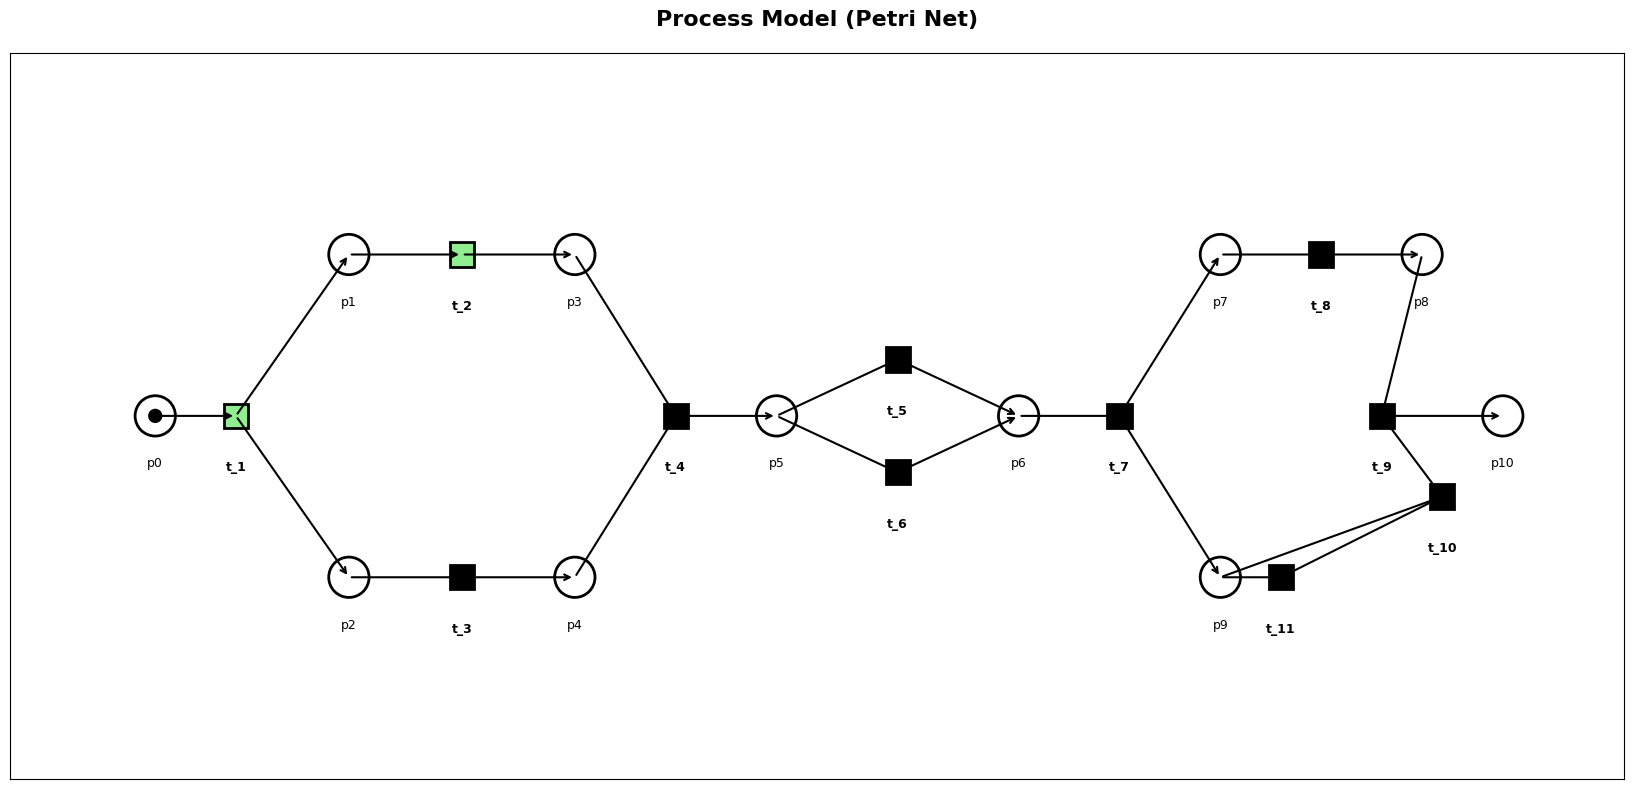

In [2]:
render_petri_net(['e1', 'e2'])  # Render with current executed events